In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, random
import numpy as np
import torch

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

SAVE_DIR = "./runs_raindrop"
os.makedirs(SAVE_DIR, exist_ok=True)
CKPT_PATH = os.path.join(SAVE_DIR, "cae_last.pth")
BEST_PATH = os.path.join(SAVE_DIR, "cae_best.pth")

device: cuda


In [3]:
import pickle
from torch.utils.data import Dataset, DataLoader

with open("16000clean7dirty.pkl", "rb") as f:
    data = pickle.load(f)

x_clean = data["clean"]                 # (16000,224,224,3) uint8
x_dirty = data["raindrop"][:1600]       # (1600,224,224,3) uint8
print("clean:", x_clean.shape, x_clean.dtype, "dirty:", x_dirty.shape, x_dirty.dtype)

class MixDataset(Dataset):
    def __init__(self, x_clean, x_dirty):
        self.x = np.concatenate([x_clean, x_dirty], axis=0)  # uint8 NHWC

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        img = self.x[idx].astype(np.float32) / 255.0     # [0,1]
        img = np.transpose(img, (2,0,1))                 # CHW
        img = torch.from_numpy(img)
        return img, img

ds = MixDataset(x_clean, x_dirty)

BATCH_SIZE = 256
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
                num_workers=0, pin_memory=True)

xb, _ = next(iter(dl))
print("batch:", xb.shape, xb.dtype, xb.min().item(), xb.max().item())

clean: (16000, 224, 224, 3) uint8 dirty: (1600, 224, 224, 3) uint8
batch: torch.Size([256, 3, 224, 224]) torch.float32 0.0117647061124444 1.0


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        # encoder: (3,224,224) -> (256)  (用 GAP 做成固定维度)
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(inplace=True),      # 112
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(inplace=True),     # 56
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(inplace=True),    # 28
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(inplace=True),   # 14
            nn.AdaptiveAvgPool2d((1,1)),                           # 1x1
        )
        self.fc = nn.Linear(256, latent_dim)

        # decoder: latent -> feature map -> upsample 回 224
        self.fc_dec = nn.Linear(latent_dim, 256*14*14)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(inplace=True),  # 28
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(inplace=True),   # 56
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(inplace=True),    # 112
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.ReLU(inplace=True),    # 224
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc(x).flatten(1)   # (B,256)
        z = self.fc(h)               # (B,latent_dim)
        return z

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 256, 14, 14)
        xrec = self.dec(h)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xrec = self.decode(z)
        return xrec, z

model = CAE(latent_dim=256).to(device)

# sanity check
with torch.no_grad():
    xb, _ = next(iter(dl))
    xb = xb.to(device)
    xrec, z = model(xb)
print("x:", xb.shape, "xrec:", xrec.shape, "z:", z.shape)

x: torch.Size([256, 3, 224, 224]) xrec: torch.Size([256, 3, 224, 224]) z: torch.Size([256, 256])


In [5]:
@torch.no_grad()
def build_href(model, ds, M=1024):
    model.eval()
    idx = np.random.choice(len(ds), size=M, replace=False)
    ref = torch.stack([ds[i][0] for i in idx], dim=0).to(device)
    _, zref = model(ref)
    return zref.detach()  # (M,D)

def latent_ref_loss(z, H_ref):
    # (B,D) vs (M,D) -> dist2 (B,M)
    z2 = (z**2).sum(dim=1, keepdim=True)
    h2 = (H_ref**2).sum(dim=1).unsqueeze(0)
    dist2 = z2 + h2 - 2.0 * (z @ H_ref.t())
    nn_idx = dist2.argmin(dim=1)
    z_near = H_ref[nn_idx]
    return F.mse_loss(z, z_near)

In [6]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# ========= config =========
EPOCHS = 100
LR = 5e-4
LAMBDA_REF = 1.0
M_REF = 1024
SAVE_EVERY = 1  # 每个 epoch 都保存一次 last，最稳

# ========= optimizer =========
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ========= resume helper =========
def try_resume(model, optimizer, ckpt_path, device):
    """
    若 ckpt_path 存在：恢复 model/optim/epoch，返回 start_epoch
    否则：返回 0
    """
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optim"])
        start_epoch = int(ckpt.get("epoch", 0))
        print(f"[resume] loaded {ckpt_path}, start_epoch={start_epoch}")
        return start_epoch
    else:
        print(f"[resume] no ckpt at {ckpt_path}, start from scratch")
        return 0

start_epoch = try_resume(model, optimizer, CKPT_PATH, device)

# best_total：简化起见不从历史恢复（不影响继续训练，只影响 best 是否更新）
best_total = 1e9
print("will train from epoch", start_epoch + 1, "to", EPOCHS)

# ========= training =========
for ep in range(start_epoch + 1, EPOCHS + 1):

    # 每个 epoch 重建 reference latent set（与你之前一致）
    H_ref = build_href(model, ds, M=M_REF)

    model.train()
    run_rec = run_ref = run_total = 0.0
    steps = 0

    for xb, _ in tqdm(dl, desc=f"epoch {ep}/{EPOCHS}", leave=False):
        xb = xb.to(device, non_blocking=True)
        xrec, z = model(xb)

        Lrec = F.mse_loss(xrec, xb)
        Lref = latent_ref_loss(z, H_ref)
        loss = Lrec + LAMBDA_REF * Lref

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        run_rec += Lrec.item()
        run_ref += Lref.item()
        run_total += loss.item()
        steps += 1

    run_rec /= steps
    run_ref /= steps
    run_total /= steps

    print(f"[ep {ep:03d}] Lrec={run_rec:.6f}  Lref={run_ref:.6f}  total={run_total:.6f}")

    # ---- save last ----
    if ep % SAVE_EVERY == 0:
        torch.save({
            "epoch": ep,
            "model": model.state_dict(),
            "optim": optimizer.state_dict(),
        }, CKPT_PATH)

    # ---- save best (based on avg total loss of this epoch) ----
    if run_total < best_total:
        best_total = run_total
        torch.save({
            "epoch": ep,
            "model": model.state_dict(),
            "optim": optimizer.state_dict(),
        }, BEST_PATH)

print("done. last:", CKPT_PATH, "best:", BEST_PATH)

[resume] loaded ./runs_raindrop\cae_last.pth, start_epoch=100
will train from epoch 101 to 100
done. last: ./runs_raindrop\cae_last.pth best: ./runs_raindrop\cae_best.pth


C:\Users\刘一芃\AppData\Local\Temp\ipykernel_17552\436499903.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


In [7]:
import numpy as np
import torch
from tqdm import tqdm

def batch_pcc(x, y, eps=1e-8):
    """
    x, y: torch tensors, shape (B, C, H, W), range [0,1]
    return: numpy array shape (B,), PCC per sample
    """
    # flatten
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)

    x = x - x.mean(dim=1, keepdim=True)
    y = y - y.mean(dim=1, keepdim=True)

    num = (x * y).sum(dim=1)
    den = torch.sqrt((x*x).sum(dim=1) + eps) * torch.sqrt((y*y).sum(dim=1) + eps)
    pcc = num / (den + eps)
    return pcc.detach().cpu().numpy()

In [8]:
# 1) 用 best 权重做推理
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# 2) 新建一个“不打乱顺序”的 dataloader
dl_eval = DataLoader(ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

all_pcc = []
with torch.no_grad():
    for xb, _ in tqdm(dl_eval, desc="eval PCC"):
        xb = xb.to(device, non_blocking=True)
        xrec, _ = model(xb)
        all_pcc.append(batch_pcc(xb, xrec))

pcc = np.concatenate(all_pcc, axis=0)   # shape (17600,)
print("pcc shape:", pcc.shape, "min/max/median:", pcc.min(), pcc.max(), np.median(pcc))

C:\Users\刘一芃\AppData\Local\Temp\ipykernel_17552\528711180.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_PATH, map_location=device)
eval PCC: 100

pcc shape: (17600,) min/max/median: 0.9347372 0.99138194 0.9776201


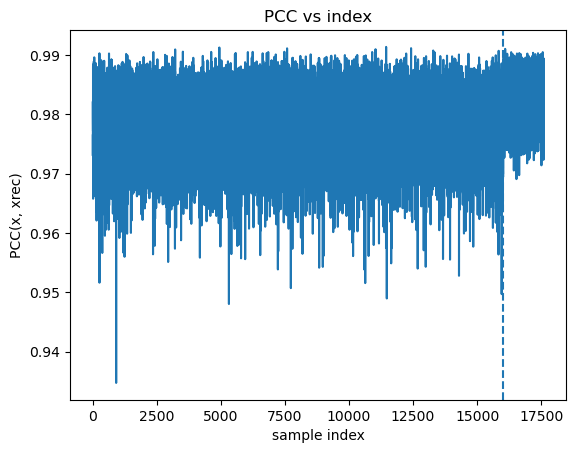

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pcc)
plt.axvline(16000, linestyle="--")   # clean/dirty 分界
plt.xlabel("sample index")
plt.ylabel("PCC(x, xrec)")
plt.title("PCC vs index")
plt.show()

pcc_med min/max/median: 0.9748832 0.98607546 0.97714347


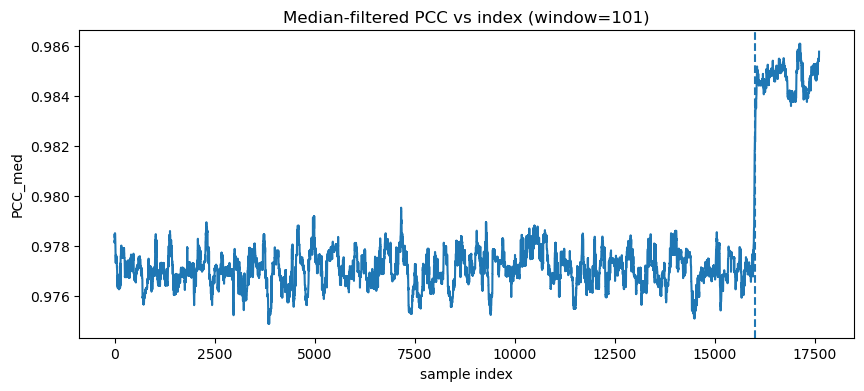

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def median_filter_1d(x, k=101):
    # k=101 对应 t-50...t+50（论文窗口100左右，写成101最对称）
    assert k % 2 == 1
    r = k // 2
    n = len(x)
    y = np.empty(n, dtype=np.float32)
    for i in range(n):
        a = max(0, i - r)
        b = min(n, i + r + 1)
        y[i] = np.median(x[a:b])
    return y

pcc_med = median_filter_1d(pcc, k=101)
print("pcc_med min/max/median:", pcc_med.min(), pcc_med.max(), np.median(pcc_med))

plt.figure(figsize=(10,4))
plt.plot(pcc_med)
plt.axvline(16000, linestyle="--")
plt.xlabel("sample index")
plt.ylabel("PCC_med")
plt.title("Median-filtered PCC vs index (window=101)")
plt.show()

delta: 0.92714345
kept ratio: 1.0 kept num: 17600 total: 17600
dirty kept ratio: 1.0 dirty kept num: 1600 dirty total: 1600


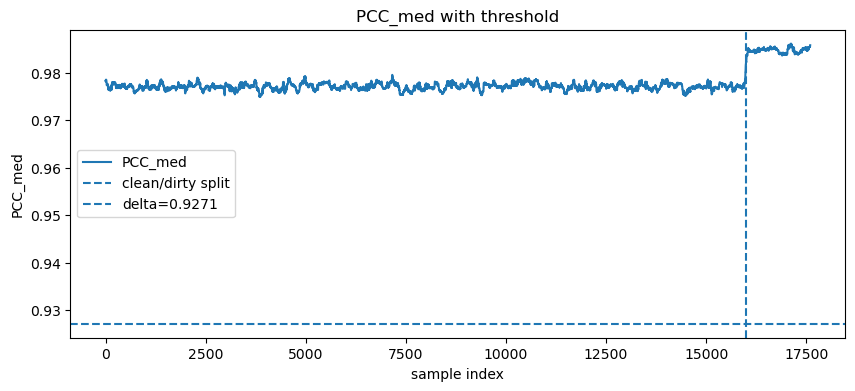

In [14]:
delta = np.median(pcc_med) - 0.05
is_clean = (pcc_med >= delta)

print("delta:", delta)
print("kept ratio:", is_clean.mean(), "kept num:", is_clean.sum(), "total:", len(is_clean))
print("dirty kept ratio:", is_clean[16000:].mean(), "dirty kept num:", is_clean[16000:].sum(), "dirty total:", len(is_clean[16000:]))

plt.figure(figsize=(10,4))
plt.plot(pcc_med, label="PCC_med")
plt.axvline(16000, linestyle="--", label="clean/dirty split")
plt.axhline(delta, linestyle="--", label=f"delta={delta:.4f}")
plt.xlabel("sample index")
plt.ylabel("PCC_med")
plt.title("PCC_med with threshold")
plt.legend()
plt.show()

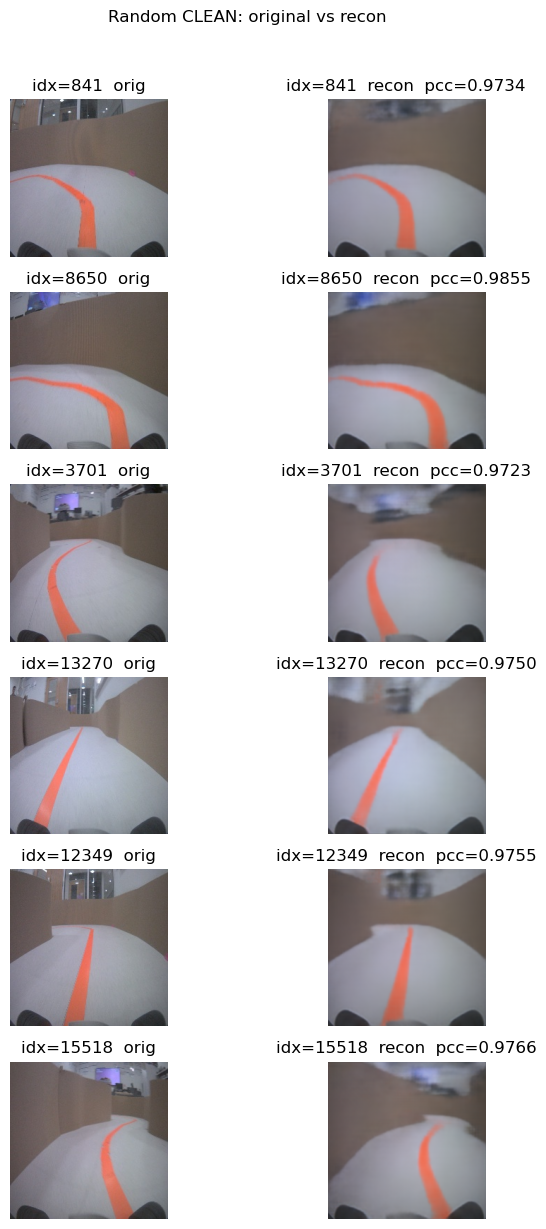

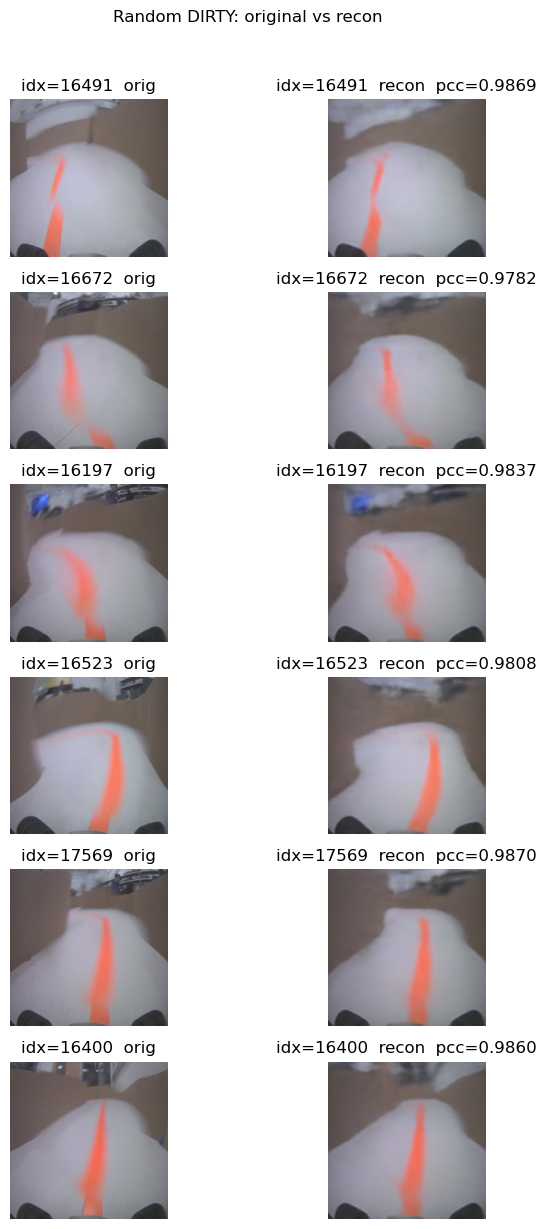

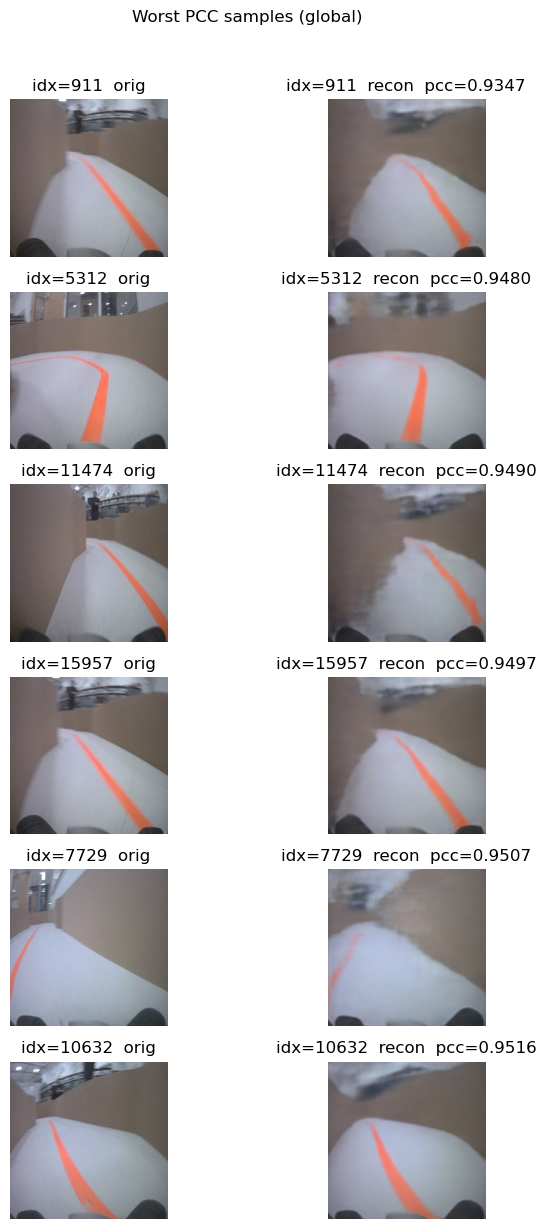

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 让 dl_eval 的 batch_size=1 更方便逐张看
dl_vis = DataLoader(ds, batch_size=1, shuffle=False, num_workers=0)

@torch.no_grad()
def get_recon(i):
    x, _ = ds[i]                 # CHW, torch
    xb = x.unsqueeze(0).to(device)
    xrec, _ = model(xb)
    x = x.numpy().transpose(1,2,0)          # HWC
    xr = xrec.squeeze(0).cpu().numpy().transpose(1,2,0)
    return x, xr

def show_pairs(idxs, title):
    n = len(idxs)
    plt.figure(figsize=(8, 2*n))
    for r, i in enumerate(idxs):
        x, xr = get_recon(i)
        # 原图
        plt.subplot(n, 2, 2*r+1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(f"idx={i}  orig")
        # 重建
        plt.subplot(n, 2, 2*r+2)
        plt.imshow(xr)
        plt.axis("off")
        plt.title(f"idx={i}  recon  pcc={pcc[i]:.4f}")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# 1) 随机看 clean 8 张
clean_idxs = np.random.choice(np.arange(0,16000), size=6, replace=False)
show_pairs(clean_idxs, "Random CLEAN: original vs recon")

# 2) 随机看 dirty 8 张
dirty_idxs = np.random.choice(np.arange(16000,17600), size=6, replace=False)
show_pairs(dirty_idxs, "Random DIRTY: original vs recon")

# 3) 看 PCC 最低的 6 张（全局最异常）
worst = np.argsort(pcc)[:6]
show_pairs(worst, "Worst PCC samples (global)")

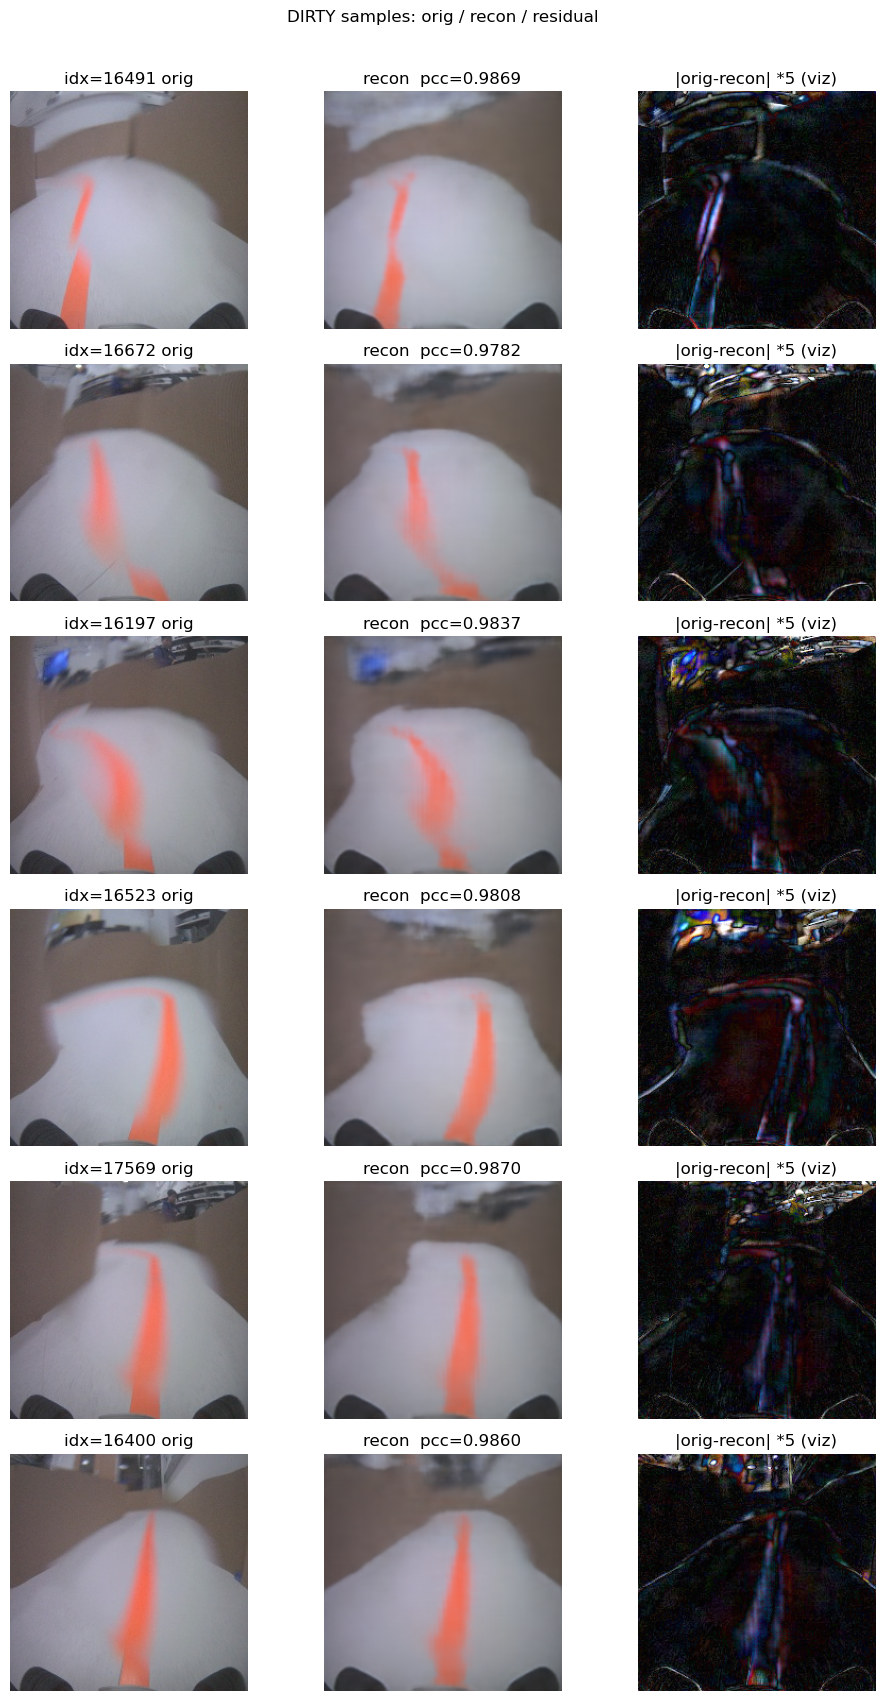

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def show_triplets(idxs, title):
    n = len(idxs)
    plt.figure(figsize=(10, 2.8*n))
    for r, i in enumerate(idxs):
        x, xr = get_recon(i)
        diff = np.abs(x - xr)
        # 为了更好看，把 diff 拉伸一下（不改变数据，只是显示）
        diff_show = np.clip(diff * 5.0, 0, 1)

        plt.subplot(n, 3, 3*r+1)
        plt.imshow(x); plt.axis("off")
        plt.title(f"idx={i} orig")

        plt.subplot(n, 3, 3*r+2)
        plt.imshow(xr); plt.axis("off")
        plt.title(f"recon  pcc={pcc[i]:.4f}")

        plt.subplot(n, 3, 3*r+3)
        plt.imshow(diff_show); plt.axis("off")
        plt.title("|orig-recon| *5 (viz)")
    plt.suptitle(title, y=1.01)
    plt.tight_layout()
    plt.show()

# 用你刚才截图里的 dirty indices（也可以换成你自己的）
dirty_idxs = [16491, 16672, 16197, 16523, 17569, 16400]
show_triplets(dirty_idxs, "DIRTY samples: orig / recon / residual")

eval MSE: 100%|██████████| 69/69 [00:22<00:00,  3.04it/s]

mse min/max/median: 0.00032503452 0.0031985969 0.0009954491


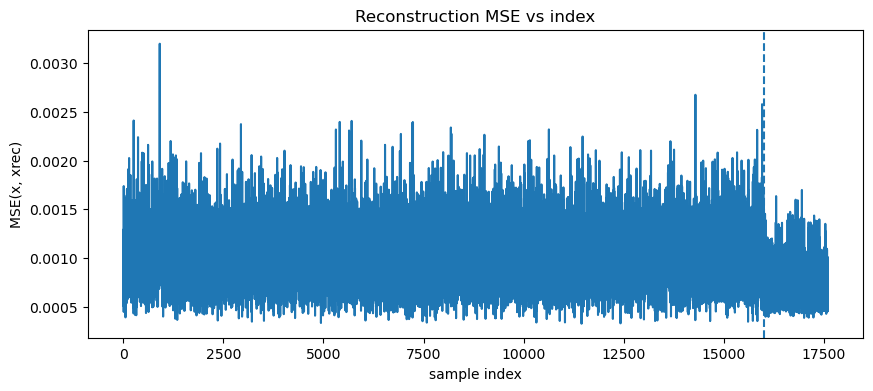

In [17]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dl_eval = DataLoader(ds, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

all_mse = []
model.eval()
with torch.no_grad():
    for xb, _ in tqdm(dl_eval, desc="eval MSE"):
        xb = xb.to(device, non_blocking=True)
        xrec, _ = model(xb)
        # 每张图一个 MSE
        mse = ((xb - xrec)**2).mean(dim=(1,2,3))
        all_mse.append(mse.detach().cpu().numpy())

mse = np.concatenate(all_mse, axis=0)
print("mse min/max/median:", mse.min(), mse.max(), np.median(mse))

plt.figure(figsize=(10,4))
plt.plot(mse)
plt.axvline(16000, linestyle="--")
plt.xlabel("sample index")
plt.ylabel("MSE(x, xrec)")
plt.title("Reconstruction MSE vs index")
plt.show()

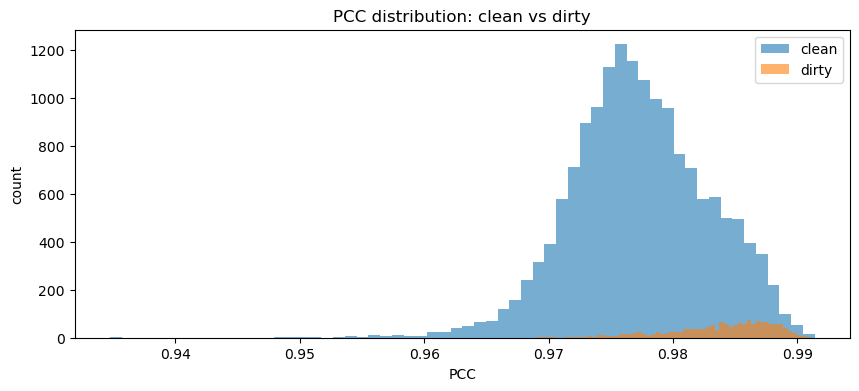

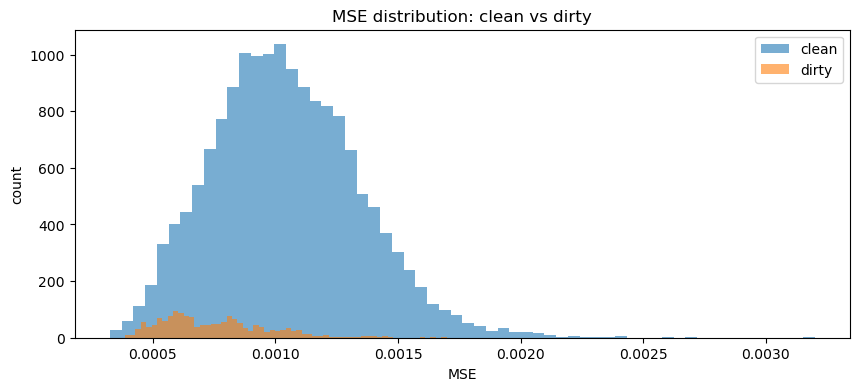

PCC median clean/dirty: 0.97704345 0.9847033
MSE median clean/dirty: 0.0010225128 0.0007133731


In [18]:
import matplotlib.pyplot as plt
import numpy as np

clean_pcc = pcc[:16000]
dirty_pcc = pcc[16000:]
clean_mse = mse[:16000]
dirty_mse = mse[16000:]

plt.figure(figsize=(10,4))
plt.hist(clean_pcc, bins=60, alpha=0.6, label="clean")
plt.hist(dirty_pcc, bins=60, alpha=0.6, label="dirty")
plt.title("PCC distribution: clean vs dirty")
plt.xlabel("PCC")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(clean_mse, bins=60, alpha=0.6, label="clean")
plt.hist(dirty_mse, bins=60, alpha=0.6, label="dirty")
plt.title("MSE distribution: clean vs dirty")
plt.xlabel("MSE")
plt.ylabel("count")
plt.legend()
plt.show()

print("PCC median clean/dirty:", np.median(clean_pcc), np.median(dirty_pcc))
print("MSE median clean/dirty:", np.median(clean_mse), np.median(dirty_mse))

In [19]:
out_path = "filter_result_raindrop.npz"
np.savez(
    out_path,
    pcc=pcc.astype(np.float32),
    pcc_med=pcc_med.astype(np.float32),
    mse=mse.astype(np.float32),
    delta=np.float32(delta),
    is_clean=is_clean.astype(np.bool_)
)
print("saved:", out_path, "keys:", np.load(out_path).files)

saved: filter_result_raindrop.npz keys: ['pcc', 'pcc_med', 'mse', 'delta', 'is_clean']
